In [198]:
import joblib
import pandas as pd
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 

In [270]:
scaler = joblib.load('2020513gpoutnoise/scaler.joblib')
vt = joblib.load('2020513gpoutnoise/vt.joblib')
sfs = joblib.load('2020513gpoutnoise/sfs.joblib')

In [271]:
df_train = pd.read_csv('../data/development_set.csv')
df_test = pd.read_csv('../data/holdout_set.csv')

In [272]:
CHEMICAL_FEATURES = (
        metalcenter_descriptors
        + functionalgroup_descriptors
        + linker_descriptors
        + mol_desc
        + summed_functionalgroup_descriptors
        + summed_linker_descriptors
        + summed_metalcenter_descriptors
    )

In [273]:
X_train = df_train[CHEMICAL_FEATURES]
X_test = df_test[CHEMICAL_FEATURES]

In [274]:
df_chris = pd.read_csv('../notebooks/chris_descriptors.csv')
df_new = pd.read_csv('../notebooks/new_descriptors.csv')

In [275]:
X_chris = df_chris[CHEMICAL_FEATURES]
X_new = df_new[CHEMICAL_FEATURES]

In [276]:
yscaler = StandardScaler()
y_train = yscaler.fit_transform(df_train[['r', 'g', 'b']])
y_test = yscaler.transform(df_test[['r', 'g', 'b']])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3c5b6710>)

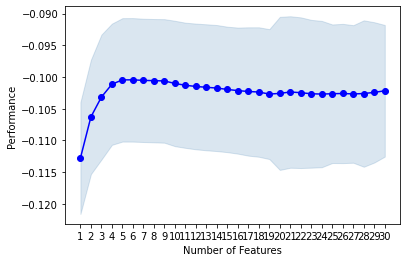

In [212]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict())

In [286]:
sfs.get_metric_dict()[10]

{'feature_idx': (0, 4, 5, 114, 137, 139, 176, 178, 188, 190),
 'cv_scores': array([-0.10149103, -0.09171885, -0.09519617, -0.09692281, -0.11977126]),
 'avg_score': -0.1010200242918804,
 'feature_names': ('0',
  '4',
  '5',
  '114',
  '137',
  '139',
  '176',
  '178',
  '188',
  '190'),
 'ci_bound': 0.012711352680391422,
 'std_dev': 0.00988986423177354,
 'std_err': 0.00494493211588677}

In [277]:
X_train = vt.transform(X_train)
X_test = vt.transform(X_test)
X_chris = vt.transform(X_chris)
X_new = vt.transform(X_new)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_chris = scaler.transform(X_chris)
X_new = scaler.transform(X_new)

In [278]:
feat = [0,
  4,
  5,
  34,
  36,
  45,
  47,
  56,
  72,
  74,
  84,
  114,
  137,
  139,
  149,
  151,
  176,
  178,
  188,
  190]

In [279]:
X_train = X_train[:, feat]
X_test = X_test[:, feat]
X_chris = X_chris[:, feat]
X_new = X_new[:, feat]

In [280]:
name_train = df_train['color_cleaned']
name_test = df_test['color_cleaned']

In [281]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, RationalQuadratic

In [282]:
gp = sfs.estimator

In [283]:
gp.n_restarts_optimizer = 30
gp.kernel = RationalQuadratic(length_scale=0.1, length_scale_bounds=(1e-6,.5)) + WhiteKernel(0.01, (1e-3, .8e-1))
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RationalQuadratic(alpha=1, length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=30, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [242]:
gp.kernel_

RationalQuadratic(alpha=0.0406, length_scale=1.12e-05) + WhiteKernel(noise_level=0.08)

In [234]:
predictions = gp.predict(X_test)



In [87]:
joblib.dump(gp, 'best_model_so_for_rq_2.joblib')

['best_model_so_for_rq_2.joblib']

In [220]:
predictions = gp.predict(X_test, return_std=True)

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


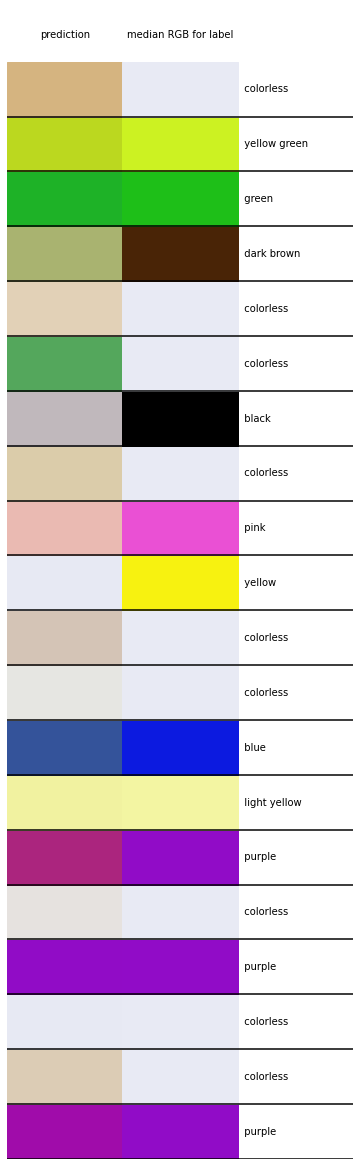

In [287]:
plot_predictions(yscaler.inverse_transform(predictions), yscaler.inverse_transform(y_test),  name_test.values,  sample=20)

In [289]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def get_metrics(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    
    return {
        'r2': r2,
        'mae': mae,
        'mse': mse
    }

In [290]:
get_metrics(y_test, predictions)

{'r2': 0.4254127751703806, 'mae': 0.5277814106223865, 'mse': 0.594657552413356}

In [224]:
samples = gp.sample_y(X_test[0:1], 200)

In [225]:
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

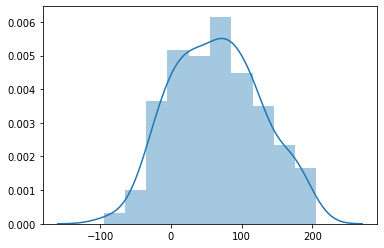

In [226]:
sns.distplot((samples[0][0] + 0.5) * 255 )

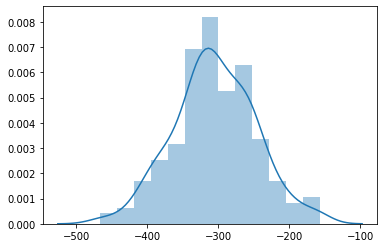

In [227]:
sns.distplot((samples[0][1] + 0.5) * 255 )

In [256]:
chris_predict = gp.predict(X_chris)
new_predict = gp.predict(X_new)

In [237]:
chris_predict

array([[ 0.2942583 ,  0.27497884,  0.26036616],
       [-0.16903178, -0.1917214 , -0.38944439],
       [ 0.29429402,  0.27494908,  0.26030513]])

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


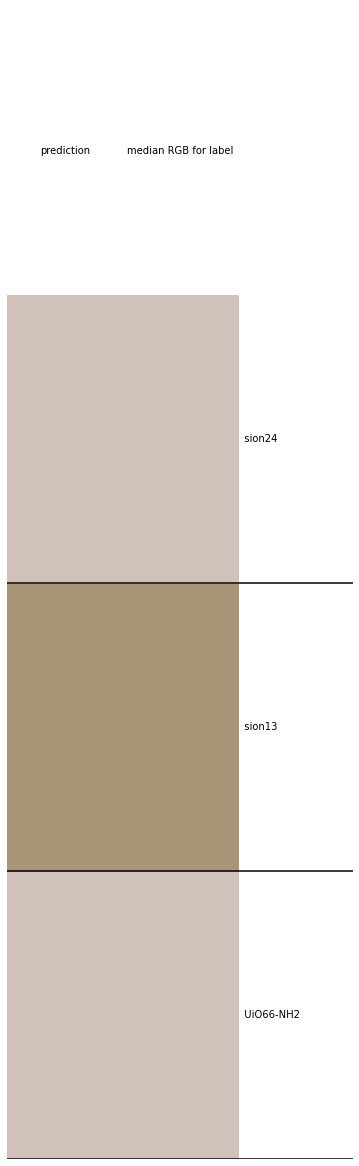

In [257]:
plot_predictions(yscaler.inverse_transform(chris_predict), yscaler.inverse_transform(chris_predict), df_chris['name'])

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


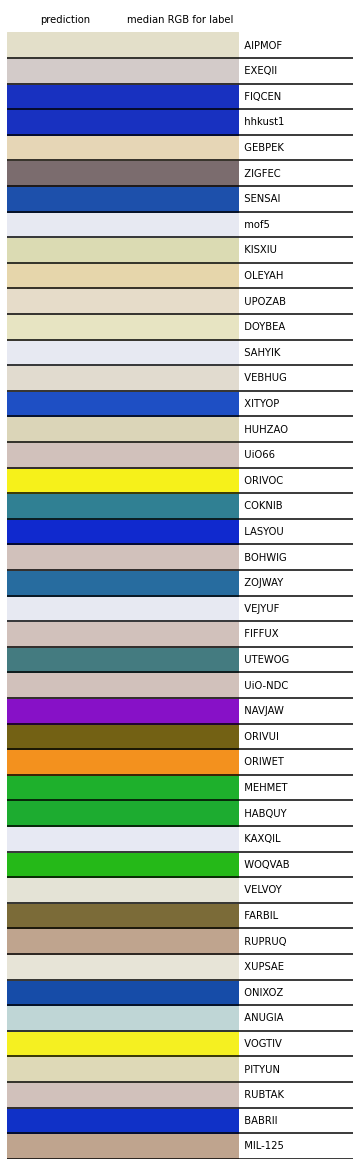

In [258]:
plot_predictions(yscaler.inverse_transform(new_predict), yscaler.inverse_transform(new_predict), df_new['name'])

['Unnamed: 0',
 'mc_CRY-chi-0-all',
 'mc_CRY-chi-1-all',
 'mc_CRY-chi-2-all',
 'mc_CRY-chi-3-all',
 'mc_CRY-Z-0-all',
 'mc_CRY-Z-1-all',
 'mc_CRY-Z-2-all',
 'mc_CRY-Z-3-all',
 'mc_CRY-I-0-all',
 'mc_CRY-I-1-all',
 'mc_CRY-I-2-all',
 'mc_CRY-I-3-all',
 'mc_CRY-T-0-all',
 'mc_CRY-T-1-all',
 'mc_CRY-T-2-all',
 'mc_CRY-T-3-all',
 'mc_CRY-S-0-all',
 'mc_CRY-S-1-all',
 'mc_CRY-S-2-all',
 'mc_CRY-S-3-all',
 'D_mc_CRY-chi-0-all',
 'D_mc_CRY-chi-1-all',
 'D_mc_CRY-chi-2-all',
 'D_mc_CRY-chi-3-all',
 'D_mc_CRY-Z-0-all',
 'D_mc_CRY-Z-1-all',
 'D_mc_CRY-Z-2-all',
 'D_mc_CRY-Z-3-all',
 'D_mc_CRY-I-0-all',
 'D_mc_CRY-I-1-all',
 'D_mc_CRY-I-2-all',
 'D_mc_CRY-I-3-all',
 'D_mc_CRY-T-0-all',
 'D_mc_CRY-T-1-all',
 'D_mc_CRY-T-2-all',
 'D_mc_CRY-T-3-all',
 'D_mc_CRY-S-0-all',
 'D_mc_CRY-S-1-all',
 'D_mc_CRY-S-2-all',
 'D_mc_CRY-S-3-all',
 'func-chi-0-all',
 'func-chi-1-all',
 'func-chi-2-all',
 'func-chi-3-all',
 'func-Z-0-all',
 'func-Z-1-all',
 'func-Z-2-all',
 'func-Z-3-all',
 'func-I-0-all',
 'func-I